In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
compiled_csv = '/mnt/disk15tb/mmpatil/MEA_Analysis_FEB25/AnalyzedData/CDKL5-E6D_T1_C1/CDKL5-E6D_T1_C1/compiledNetworkData.csv'

df = pd.read_csv(compiled_csv)

df.columns

Index(['Number_Bursts', 'mean_IBI', 'cov_IBI', 'mean_Burst_Peak',
       'mean_BurstDuration', 'cov_Burst_Peak', 'fano_factor',
       'MeanWithinBurstISI', 'CoVWithinBurstISI', 'MeanOutsideBurstISI',
       'CoVOutsideBurstISI', 'MeanNetworkISI', 'CoVNetworkISI', 'NumUnits',
       'fileName', 'Date', 'ID', 'AssayType', 'Run #', 'WellID'],
      dtype='object')

In [13]:
from datetime import datetime
DIV_0_date = datetime.strptime('2024-05-15', '%Y-%m-%d')

# Convert integer date (e.g., 240523) to string and then to datetime
df['DIV'] = df['Date'].apply(lambda x: (datetime.strptime(str(x), '%y%m%d') - DIV_0_date).days)

In [14]:
# Load the reference sheet
reference_file = '/mnt/disk20tb/PrimaryNeuronData/Maxtwo/CDKL5-E6D_T1_C1/CDKL5_T1_C1_reff.xlsx'
reference_df = pd.read_excel(reference_file)

# Normalize the reference sheet: Expand rows for each well
def expand_reference_row(row):
    wells = [w.strip() for w in str(row['Wells_Recorded']).split(',')]
    sources = [s.strip() for s in str(row['Neuron Source']).split(',')]
    # If both are single values, just expand one row
    if len(wells) == 1 and len(sources) == 1:
        return [{
            'Date': row['Date'],
            'DIV': row['DIV'],
            'ID': row['ID'],
            'WellID': f'well{int(wells[0]) - 1:03d}',
            'Neuron Source': sources[0]
        }]
    # If lengths do not match, raise an error
    if len(wells) != len(sources):
        raise ValueError(f"Wells and sources length mismatch in row: {row}")
    expanded_rows = []
    for well, source in zip(wells, sources):
        well_id = f'well{int(well) - 1:03d}'
        expanded_rows.append({
            'Date': row['Date'],
            'DIV': row['DIV'],
            'ID': row['ID'],
            'WellID': well_id,
            'Neuron Source': source
        })
    return expanded_rows

# Apply the function to expand all rows
expanded_rows = []
for _, row in reference_df.iterrows():
    expanded_rows.extend(expand_reference_row(row))

# Create a normalized reference DataFrame
normalized_reference_df = pd.DataFrame(expanded_rows)

# Remove duplicates in the reference data
normalized_reference_df = normalized_reference_df.drop_duplicates(subset=['ID', 'DIV', 'WellID'])

In [15]:
#assign Neuron Source to df
df = df.merge(normalized_reference_df[['ID', 'DIV', 'WellID', 'Neuron Source']], on=['ID', 'DIV', 'WellID'], how='left')

In [17]:
print(df.columns)


Index(['Number_Bursts', 'mean_IBI', 'cov_IBI', 'mean_Burst_Peak',
       'mean_BurstDuration', 'cov_Burst_Peak', 'fano_factor',
       'MeanWithinBurstISI', 'CoVWithinBurstISI', 'MeanOutsideBurstISI',
       'CoVOutsideBurstISI', 'MeanNetworkISI', 'CoVNetworkISI', 'NumUnits',
       'fileName', 'Date', 'ID', 'AssayType', 'Run #', 'WellID', 'DIV',
       'Neuron Source'],
      dtype='object')


Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


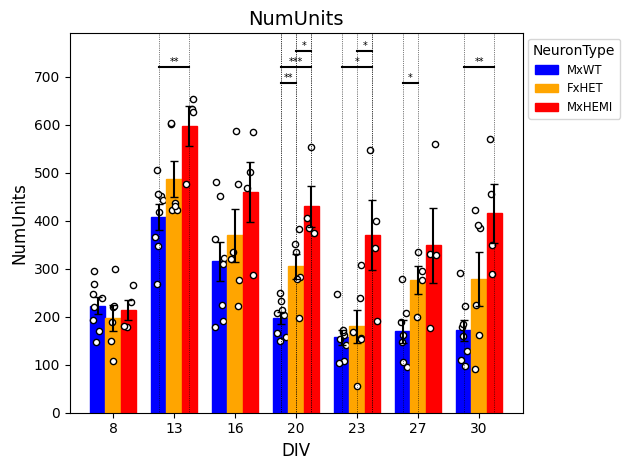

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


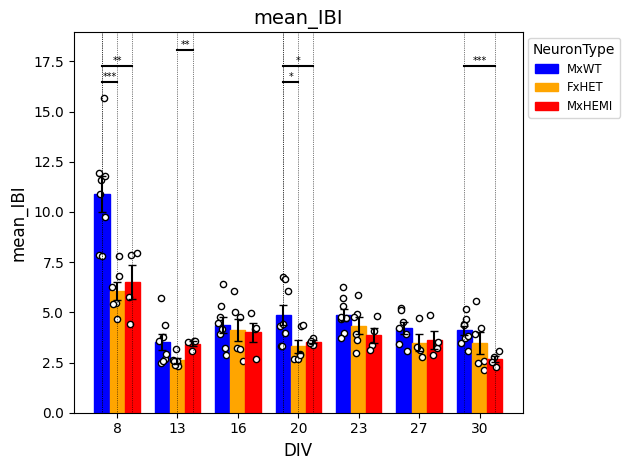

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


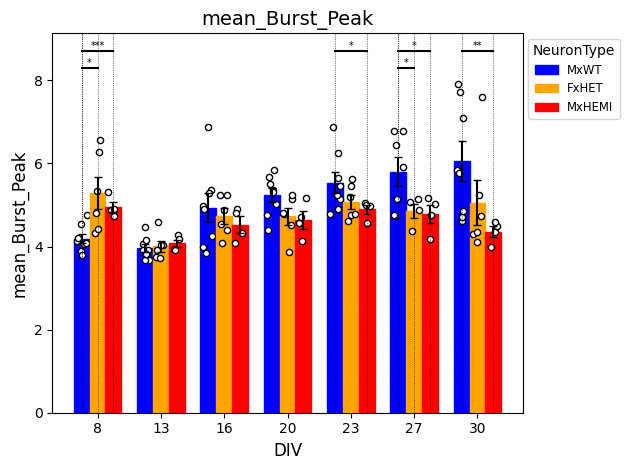

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


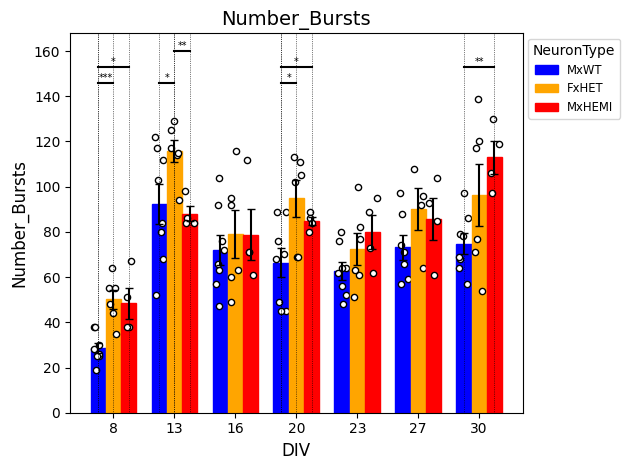

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


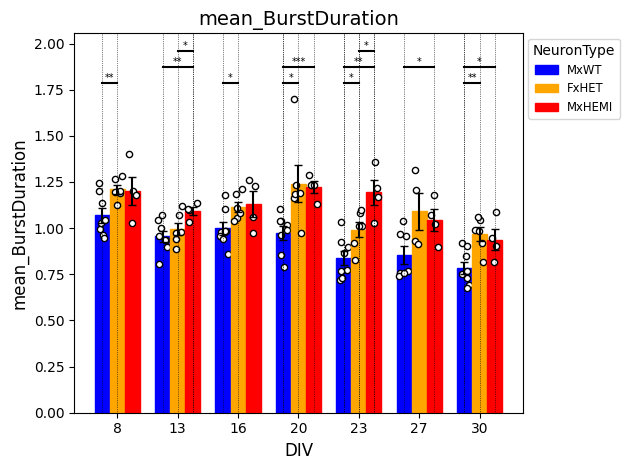

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


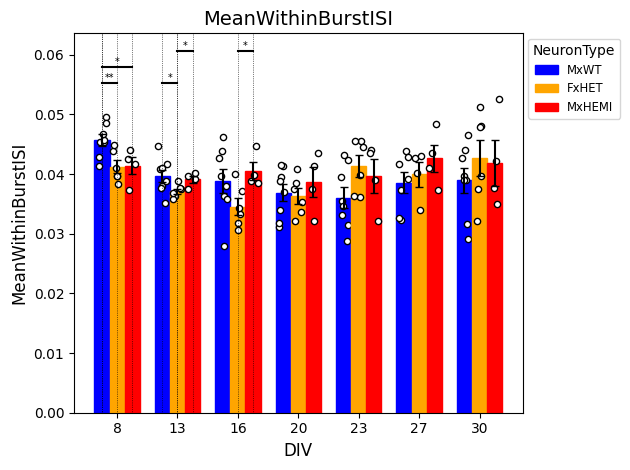

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


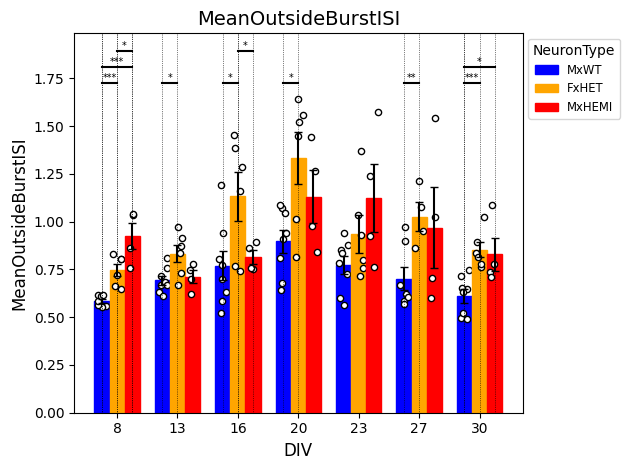

In [21]:
from math import sqrt
from scipy import stats
output_types = ['NumUnits','mean_IBI'
    , 'mean_Burst_Peak',  'Number_Bursts',
     'mean_BurstDuration','MeanWithinBurstISI','MeanOutsideBurstISI']

div = sorted(df['DIV'].unique())

unique_genotypes = [ 'MxWT', 'FxHET' ,'MxHEMI']

colors = ['blue','orange','red']
markers = ['o','o','d','*','^']

#dirpath = '/mnt/disk15tb/paula/Main_DA_Projects/data_analysis_output/Primary Neurons/CDKL5_E6T1_Apr29/plots/'
for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    #output_type='Number_Bursts'
    # Print the number of unique genotypes
    print(f"Number of unique Genotypes: {total_genotypes}")

    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    print(unique_genotypes)
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) &
                            (df['Neuron Source'].str.strip() == genotype)
                            ]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['ID']))
            well_arrays[genotype].append(np.array(temp_df['WellID']))
    #print(df)
    # Adjust bar width and gap between them
    bar_width = 0.25  # Adjust as necessary for your specific plot
    gap_between_bars = 0  # Adjust the gap between bars within a group

    # Calculate the total width for all bars in a group
    total_bar_group_width = total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars

    # Create x-coordinates of bars for each genotype group
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    base_x_coordinate = np.arange(len(div))  # Base x-coordinates for each group
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    for i, genotype in enumerate(unique_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)



    # Initialize plot
    fig, ax = plt.subplots()
    # Generate a list of distinct colors based on the number of genotypes
    #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
    #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
    # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
    # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
    # Plot data for each genotype
    mean_data_all ={}
    yerr_data_all = {}
    n_data_all={}
    #breakpoint()
    #pdb.set_trace()
    for i,genotype in enumerate(unique_genotypes):
        #breakpoint()
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        #print("type: ",type(genotype))
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
            
        # Plot bars
        #transparency value 
        alpha_value = 0.5
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, width=bar_width, color=colors[i], edgecolor=colors[i], ecolor='black', label=genotype,alpha=1.0)

        #pdb.set_trace()
        # Plot scatter points
        #breakpoint()
        for j in range(len(x_genotype[genotype])):
            #pdb.set_trace()
            # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
    # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
            combined_data = [str(chip)+ str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

            # # Check if the concatenated string is in track_chips, and set the marker accordingly
            # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
            # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

            # Use the marker in the scatter plot
            jitter_amount=0.08
            for k in range(len(y_data[j])):
                #pdb.set_trace()
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=20,
                    color='white',
                    marker='o',
                    edgecolors='black'
                        )


    # # Calculate maximum y-value for plotting significance
    # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
    # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

    #Perform and plot t-tests between all pairs of genotype
    #pdb.set_trace()
    for i in range(len(base_x_coordinate)):
        #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
        maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    #pdb.set_trace()
                    #print("mean_data_all",mean_data_all[genotype1])
                    #print("type:",type(genotype1))
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    # degrees of freedom
                    degreef = n1+n2 - 2
                    alpha=0.05
                    # calculate the critical value
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    # calculate the p-vallue
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1,sem1,mean2,sem2,p_value])

                    # Plot significance
                    #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    if not sign =='ns':
                        ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                        ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                        ax.axvline(x1,color='black',linestyle=':',linewidth=0.5)
                        ax.axvline(x2,color='black',linestyle=':',linewidth=0.5)
                    count = count +1

                    


   # Adjustments for plot aesthetics
    plt.title(f"{output_type}", fontsize=14)
    plt.xlabel('DIV', fontsize=12)
    plt.ylabel(f"{output_type}", fontsize=12)
    plt.xticks(base_x_coordinate, div, fontsize=10)

    plt.legend(title='NeuronType', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout() 
    plt.show() # Adjust layout to prevent clipping of ylabel
    #plt.legend(title='NeuronType',loc='upper right', fontsize='x-small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.0, 1))
   # import os 
    
    #if not os.path.exists(dirpath):
    #        os.makedirs(dirpath)
    #plt.savefig(f"{dirpath}/{output_type}.svg",dpi=300,format='svg')

In [ ]:
# Create figure with multiple subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot for each metric
for neuron_type in df['Neuron Source'].unique():
    mask = df['Neuron Source'] == neuron_type
    
    # Number of Bursts
    ax1.plot(df[mask]['DIV'], df[mask]['Number_Bursts'], 'o-', label=neuron_type)
    ax1.set_title('Number of Bursts')
    ax1.set_xlabel('DIV')
    ax1.set_ylabel('Count')
    
    # Mean IBI
    ax2.plot(df[mask]['DIV'], df[mask]['mean_IBI'], 'o-', label=neuron_type)
    ax2.set_title('Mean Inter-Burst Interval')
    ax2.set_xlabel('DIV')
    ax2.set_ylabel('Time (s)')
    
    # Mean Burst Peak
    ax3.plot(df[mask]['DIV'], df[mask]['mean_Burst_Peak'], 'o-', label=neuron_type)
    ax3.set_title('Mean Burst Peak')
    ax3.set_xlabel('DIV')
    ax3.set_ylabel('Peak Value')
    
    # Number of Units
    ax4.plot(df[mask]['DIV'], df[mask]['NumUnits'], 'o-', label=neuron_type)
    ax4.set_title('Number of Units')
    ax4.set_xlabel('DIV')
    ax4.set_ylabel('Count')

# Add legends
for ax in [ax1, ax2, ax3, ax4]:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

